In [23]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import LinearScale, LogScale
from scipy import signal
from mockin import *


def plot_filter(ax1, coeffs, sample_freq, filter_name, center_freq=None, logplot=True):
    b, a = coeffs
    space = np.logspace(-3, 0, 1000) if logplot else np.linspace(0, 1, 1000) + 1/1000
    w, h = signal.freqz(b, a, worN=space)

    fw = sample_freq * w

    ax1.set_title(filter_name + ' filter characteristics')

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    y1 = 20*np.log10(np.abs(h))
    if logplot:
        ax1.semilogx(fw, y1, color='blue')
    else:
        ax1.plot(fw, y1, color='blue')
    ax1.axhline(0, color='blue', linestyle='--')
    ax1.axhline(-3, color='blue', linestyle=':')  # -3 dB magnitude
    if center_freq:
        ax1.axvline(center_freq, color='blue',
                    linestyle=':')  # cutoff frequency
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude [dB]')
    ax1.margins(0, 0.1)
    ax1.grid(which='both', axis='both')

    y2 = np.angle(h)
    if logplot:
        ax2.semilogx(fw, y2, color='green')
    else:
        ax2.plot(fw, y2, color='green')
    ax2.axhline(0, color='green', linestyle='--')
    ax2.set_ylabel(None)
    ax2.set_yticks([])
    ax2.set_ylim(-np.pi, np.pi)
    ax2.margins(0, 0)

    phase = (2 * np.pi + np.angle(h)) % (2 * np.pi)
    y3 = 1000 * 2 * np.pi * phase / fw
    if logplot:
        ax3.semilogx(fw, y3, color='orange')
    else:
        ax3.plot(fw, y3, color='orange')
    ax3.axhline(0, color='orange', linestyle='--')
    ax3.set_ylim(-2, 22)
    ax3.margins(0, 0.1)
    ax3.set_ylabel('Group delay [ms]')


input_122_100 = InputMock("sample122bpm-100hz.txt", 100)
input_124_200 = InputMock("sample124bpm-200hz.txt", 200)
input_174_200 = InputMock("sample174bpm-sloppy-200hz.txt", 200)


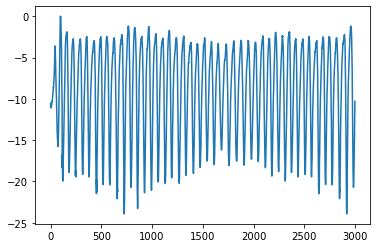

In [24]:
y = input_174_200.read_samples(3000)
input_174_200.reset()
plt.plot(range(len(y)), y)
plt.show()

In [36]:
input = input_124_200

sample_freq = input.sample_freq
sample_freq = 200

comb_q = 0.95

min_detect_bpm = 83
max_detect_bpm = 200

min_detect_samples = math.ceil(sample_freq * 60 / min_detect_bpm)
max_detect_samples = math.floor(sample_freq * 60 / max_detect_bpm)

dc_reject_coeffs = signal.butter(
    1, 0.1, fs=sample_freq, btype='highpass')
print("{ %s }," % (', '.join(map(lambda x: '%rf' % (x,), dc_reject_coeffs[0])),))
print("{ %s }" % (', '.join(map(lambda x: '%rf' % (x,), dc_reject_coeffs[1])),))

comb_coeffs = [
    (60 / n, ([1 - comb_q], [1] + ([0] * n) + [-comb_q],))
    for n in range(max_detect_samples, min_detect_samples + 1)
]

# b, a = signal.butter(3, freq, fs=sample_freq, btype='highpass')


{ 0.998431665916719f, -0.998431665916719f },
{ 1.0f, -0.996863331833438f }


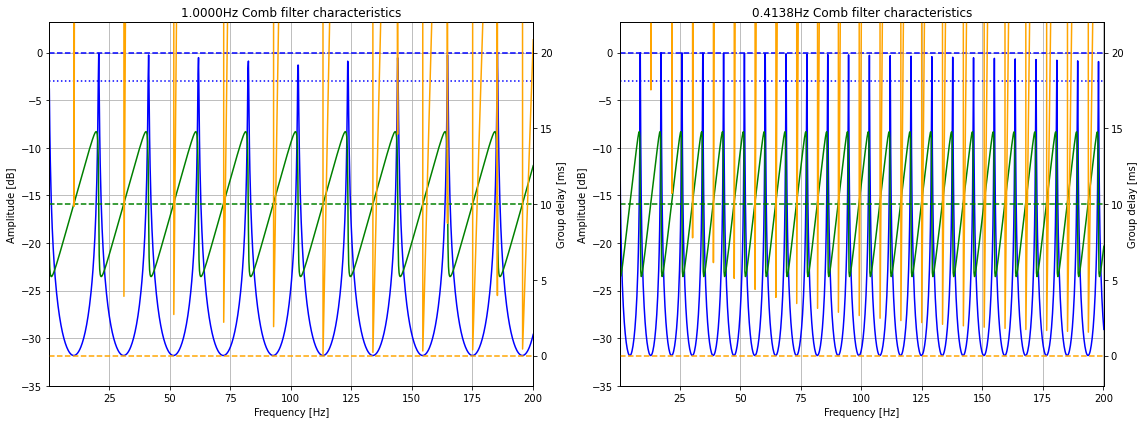

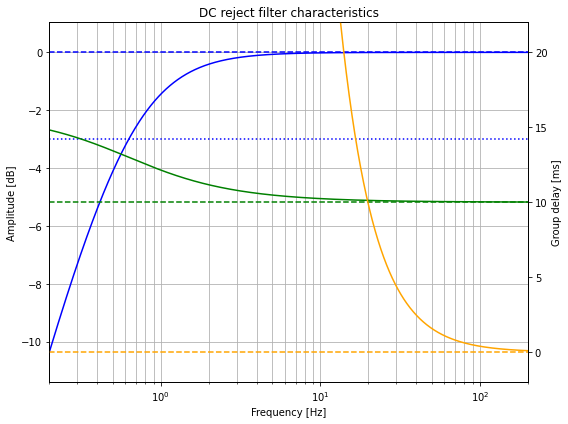

In [35]:
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(16, 6))
plot_filter(ax_l, comb_coeffs[0][1], sample_freq, '%.4fHz Comb' % (comb_coeffs[0][0],), logplot=False)
plot_filter(ax_r, comb_coeffs[-1][1], sample_freq, '%.4gHz Comb' % (comb_coeffs[-1][0],), logplot=False)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_filter(ax, dc_reject_coeffs, sample_freq, 'DC reject', logplot=True)
fig.tight_layout()
plt.show()
